# Opinion Mining & Sentiment Analysis: Lab Activities

**Text Mining unit**

_Prof. Gianluca Moro, Dott. Ing. Roberto Pasolini – DISI, University of Bologna_

**Bologna Business School** - Alma Mater Studiorum Università di Bologna

## Setup

Import external libraries (thus verifying they are correctly installed)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import nltk

If using IPython/Jupyter, run the following to render plots inline

In [2]:
%matplotlib inline

Set some options in pandas for printing DataFrames

In [3]:
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

Define a utility function to download data files if they are not already present in working directory

In [4]:
import os
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.exists(file):
        urlretrieve(url, file)

## Activity 1: Twitter Opinion Mining

**Goal:** evaluate from Twitter how much customers are satisfied of airline companies

1. Collect tweets citing airline companies
2. Define lists of opinion keywords
3. Evaluate sentiment of each tweet
4. Summarize sentiment for each airline company
5. Extract customer satisfaction for companies from the ACSI website
6. Compare scores estimated from Twitter with those extracted from ACSI

This is a list of the Twitter accounts of airline companies taken into consideration

In [5]:
airlines = [
    "delta",
    "americanair",
    "jetblue",
    "southwestair",
    "united"
]

### Collect tweets citing airline companies

Recent tweets matching a given query can be searched using the Twitter Search API; many libraries exist for Python and other languages providing easy access to the API

We see here how to obtain tweets using the `TwitterSearch` package, installable with `pip install TwitterSearch`; a Twitter account with an associated mobile number is needed in order to use the API

If you can't or don't want to use your Twitter account and/or install the package, you can use a set of pre-collected tweets we provide

#### Creating a Twitter application

In order to use Twitter APIs you need API keys: follow these steps to obtain one

1. Go to https://developer.twitter.com/en/apps and login with your Twitter account
2. Click the "Create New App" button, fill the form with short descriptive values (you may use e.g. "http://example.com" as the URL) and confirm
3. Click on the app you just created and open the "Key and Access Tokens" tab
4. For better security, ensure to set the Access Level to Read-only
5. Click on the "Create my access token" button below

You will need strings labeled with _Consumer Key_, _Consumer Secret_, _Access Token_ and _Access Token Secret_ shown in the page to use the API

#### Authenticating

Import the necessary classes and create a `TwitterSearch` object providing the API codes obtained above

In [6]:
from TwitterSearch import TwitterSearch, TwitterSearchOrder
ts = TwitterSearch(
    consumer_key="yWpAzNQudCFypHUACLVmeQ",
    consumer_secret="kCxyi29aVaZv7qQA1bM8Tt60rzUReD0Zaes2w6m1iU",
    access_token="1678583318-WAc1sc3oVuOqrU4DV3KZZAm024jyCic3kzMNtZl",
    access_token_secret="wjay7Z4uTMOXkEsRD4soIBMC7eCjG0Jk8giGDWOg"
)

#### Obtaining tweets

Create a `TwitterSearchOrder` indicating the tweets to search: we start for example by searching tweets about Delta Air Lines, whose Twitter account is "@delta"; by default the search will return up to 100 tweets, the upper limit set by Twitter for each request

In [7]:
tso = TwitterSearchOrder()
tso.set_keywords(["@delta"])
tso.set_language("en")
tso.set_include_entities(False)

We can now issue the request to the Twitter API

**Warning:** the Twitter API has usage rate limitations, `search_tweets` and other API methods will temporarily stop working if executed many times in few minutes

In [8]:
tsresp = ts.search_tweets(tso)

We obtain an object with detailed information about the request and the response by Twitter, to obtain the list of tweets:

In [9]:
delta_tweets = tsresp["content"]["statuses"]

For each tweet we have an object with many details: among the key ones we have its unique ID, the name of the author and its actual text

In [10]:
delta_tweets[0]["id"]

1133508786646392841

In [11]:
delta_tweets[0]["user"]["name"]

'DCHoosier'

In [12]:
delta_tweets[0]["text"]

'@Delta Many many thanks to Maria at B15 at DCA!! She is a superstar of customer service!!'

Define a function to repeat the operations given above on any search string and return a list of the contents of each tweet (without metadata)

In [13]:
def get_recent_tweets(query):
    print("getting tweets for '{}' ... ".format(query), end="")
    tso = TwitterSearchOrder()
    tso.set_keywords([query])
    tso.set_language("en")
    tso.set_include_entities(False)
    tsresp = ts.search_tweets(tso)
    texts = [status["text"] for status in tsresp["content"]["statuses"]]
    print("{} retrieved".format(len(texts)))
    return texts

Use then this function to create a dictionary mapping airline names to list of relevant tweets

In [14]:
current_tweets = {
    airline: get_recent_tweets("@" + airline)
    for airline in airlines
}

getting tweets for '@delta' ... 100 retrieved
getting tweets for '@americanair' ... 100 retrieved
getting tweets for '@jetblue' ... 100 retrieved
getting tweets for '@southwestair' ... 100 retrieved
getting tweets for '@united' ... 99 retrieved


### Using pre-collected tweets

For convenience, we provide a set of precollected tweets about the airline companies as an alternative to latest tweets

In [15]:
download("tweets.zip", "https://www.dropbox.com/s/umqtqi9bwvlrr6z/tweets.zip?dl=1")

The ZIP archive contains a `company_name.txt` file for each airline company, each with a list of tweets (one per line): we load them into a dict mapping the name of each company to the list of relevant tweets

In [16]:
from zipfile import ZipFile
archive_tweets = {}
with ZipFile("tweets.zip") as zipf:
    for airline in airlines:
        with zipf.open(airline + ".txt") as f:
            archive_tweets[airline] = list(line.decode().strip() for line in f)

You can read for example some tweets about Delta airlines:

In [17]:
archive_tweets["delta"][:3]

['"@LAKings: Are you the #LAKings biggest fan? Prove it and win a trip on @Delta to see the Kings vs Rangers in NY - http://t.co/JXBc5kDXnZ"RT',
 '@AneetharPweety am @delta state buh on ma way to benin city now',
 'RT @iamdiddy: If you’re flying out of JFK on @Delta you NEED to check out the new @CIROC VIP lounge at @Delta terminal at JFK. http://t.co/…']

In the following we will work on these `archive_tweets`, replace that in the line below with `current_tweets` if you want to use downloaded tweets instead

In [18]:
tweets = archive_tweets

To better deal with them later, we represents tweets into a pandas DataFrame with two columns
- a `text` column with the text of the tweet
- an `airline` column with the airline each tweet refers to

In [19]:
tweets = pd.DataFrame(
    {"airline": airline, "text": text}
    for airline, tweetlist in tweets.items()
    for text in tweetlist
)

In [20]:
tweets.head(3)

,airline,text
0,southwestair,Darn you southwest and your cheap online deals! So tempting.. #travel @SouthwestAir
1,southwestair,@LedddyLuv @SouthwestAir so jealous
2,southwestair,"Ah, sales on @SouthwestAir - well, it's like the early Christmas gift you say you deserve to buy..."


### Estimating sentiment using lists of opinion words

Several methods and algorithms have been proposed in literature to estimate the sentiment of a document (or sentence), usually quite complex.

To get started, we will use a trivial lexicon-based method which assigns a score by counting known positive and negative words in each tweet.

Hu and Liu made available for download a list of about 6,800 words labeled as either positive or negative.

- **Positive:** love, best, cool, great, good, amazing, ...
- **Negative:** hate, worst, sucks, awful, nightmare, ...

We write
- a function used to process word lists, ignoring lines either empty or starting with ";" (comments)
- another function using the first one to get a set of words contained in a named file

In [21]:
def scan_hu_liu(f):
    for line in f:
        line = line.decode(errors="ignore").strip()
        if line and not line.startswith(";"):
            yield line

def load_hu_liu(filename):
    with open(filename, "rb") as f:
        return set(scan_hu_liu(f))

We then download the two sets (one for positive words and one for negative ones) and use the latter function to load them

In [22]:
download("positive-words.txt", "https://www.dropbox.com/s/pmju477pv8ayzho/positive-words.txt?dl=1")
download("negative-words.txt", "https://www.dropbox.com/s/yy4l1ezlrsar8cf/negative-words.txt?dl=1")
hu_liu_pos = load_hu_liu("positive-words.txt")
hu_liu_neg = load_hu_liu("negative-words.txt")

The words in the list are general, but we can add some domain-specific word ("`|`" is the "set union" operator)

In [23]:
airline_pos_words = hu_liu_pos | {"upgrade"}
airline_neg_words = hu_liu_neg | {"wtf", "wait", "waiting", "epicfail", "mechanical"}

_Performance note:_ we use sets here (denoted with braces: `{...}`) rather than lists (with square brackets: `[...]`) to make lookup faster

In [24]:
%%timeit -n 1000000
"e" in ["a", "b", "c", "d", "e"]   # list

63.4 ns ± 0.932 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [25]:
%%timeit -n 1000000
"e" in {"a", "b", "c", "d", "e"}   # set

21.6 ns ± 0.497 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### Text tokenization

We have to decompose tweets into the single words they contain in order to search for the opinion words within it

A _tokenization_ algorithm splits a text string into a sequence of _tokens_ each representing a single word (or other entities such as numbers and punctuation)

A simple tokenization algorithm can consist in removing all characters different from letters and spaces from text, than splitting text in words using spaces as boundaries

In [26]:
import re
def my_tokenizer(text):
    return re.sub("[^A-Za-z ]", "", text).split(" ")

An example usage is...

In [27]:
my_tokenizer("This isn't a test, or is it?")

['This', 'isnt', 'a', 'test', 'or', 'is', 'it']

NLTK provides a finer tokenization algorithm, based on a knowledge model of the English language: in order to make it work, we have first to download the model

In [28]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/rrobby/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We can then use the `word_tokenize` function

In [29]:
nltk.word_tokenize("This isn't a test, or is it?")

['This', 'is', "n't", 'a', 'test', ',', 'or', 'is', 'it', '?']

Other than keeping punctuation marks as separate tokens, NLTK was able to correctly split "isn't" into its two component words

### Sentiment scoring

We define a function to compute the "sentiment score" of some text, computed as the difference between counts of positive and negative opinion words contained in it. Notice we have to convert all words in lowercase to be sure to find them in the lists.

In [30]:
def sentiment_score(text, pos_words, neg_words):
    words = nltk.word_tokenize(text)
    # count 1 for each word present in the positive words list
    pos_matches = sum(1 for word in words if word.lower() in pos_words)
    # same count with the negative words list
    neg_matches = sum(1 for word in words if word.lower() in neg_words)
    # return the difference between the two counts
    return pos_matches - neg_matches

This functions accept the lists of positive and negative words as input, we can wrap it in a version specific for the "airline" opinion words lists

In [31]:
def airline_sentiment_score(text):
    return sentiment_score(text, airline_pos_words, airline_neg_words)

Example: a sentence with one positive word...

In [32]:
airline_sentiment_score("This is an awesome test!")

1

Let's consider a small set of sample sentences to evaluate

In [33]:
sample = [
    "You're awesome and I love you",
    "I hate and hate and hate. So angry. Die!",
    "Impressed and amazed: you are peerless in your achievement of unparalleled mediocrity."
]

We can use `map` to apply the scoring function to each of the samples and get the sequence of corresponding scores wrapped in a list

In [34]:
sample_scores = list(map(airline_sentiment_score, sample))

In [35]:
sample_scores

[2, -5, 4]

Using a pandas DataFrame, we can get a table of sample sentences matched with scores

In [36]:
pd.DataFrame({"score": sample_scores, "text": sample})

,score,text
0,2,You're awesome and I love you
1,-5,I hate and hate and hate. So angry. Die!
2,4,Impressed and amazed: you are peerless in your achievement of unparalleled mediocrity.


As we can see, the scoring function correctly evaluates straightforward sentences, although it fails to detect more elaborate text (e.g. using sarcasm)

Let's apply the scoring functions to all tweets for one of the companies, e.g. Delta. We wrap scores in a pandas Series so we can use its functionalities.

In [37]:
delta_scores = pd.Series(map(airline_sentiment_score, tweets["text"][tweets["airline"] == "delta"]))

We can get for example the mean score of tweets...

In [38]:
delta_scores.mean()

0.23406113537117904

...and even plot an histogram of the distribution of scores

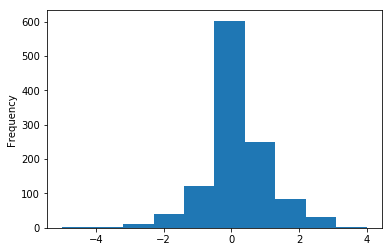

In [39]:
delta_scores.plot.hist()

Let's now work with the whole collection of tweets related to all airlines

We compute sentiment scores for each tweet by applying the `airline_sentiment_score` function to the `text` columns; scores are saved in a `score` column added to a copy of the `tweets` DataFrame

In [40]:
tweets_with_scores = tweets.copy()
tweets_with_scores["score"] = tweets_with_scores["text"].apply(airline_sentiment_score)

Let's see some random rows from it...

In [41]:
tweets_with_scores.sample(5)

,airline,text,score
4246,united,"@united Thanks they book me ok. No way to get there today, but hotel in Sjo said will charge the...",0
3117,americanair,ope so too; #Pasta dishes on AA int'l flights are the ones I have tasted &amp; like.,1
4239,united,Yup. RT @nyc2theworld: @joelfreak @WanderngAramean @united EWR airport rail station...i recogniz...,-1
2460,americanair,"Seeing a lot more @AmericanAir planes with the new trade dress. Not mine today, tho. Maybe tomo...",0
3180,united,"hey @united can you email my teacher, because I have class tomorrow and your delays are killing ...",-2


### Summarizing sentiment for each company

Let’s focus our analysis only on very negative (score <= 2) and very positive (score >= 2) tweets, adding columns which identify them

In [42]:
tweets_with_scores["very_pos"] = tweets_with_scores["score"] >= 2
tweets_with_scores["very_neg"] = tweets_with_scores["score"] <= -2

We group the frame by companies, keeping just the columns indicating very positive or negative tweets and counting the number of them for each group

In [43]:
twitter_score = tweets_with_scores.groupby("airline")["very_pos", "very_neg"].sum().sort_index()

Let's view the obtained grouped table...

In [44]:
twitter_score

,very_pos,very_neg
airline,,
americanair,118.0,31.0
delta,116.0,55.0
jetblue,10.0,2.0
southwestair,122.0,34.0
united,116.0,99.0


`airline` is now the _index_ of the frame: values of the index identify each row (much like a primary key in a database)

For every company, we compute the sum of very positive and very negative tweets...

In [45]:
twitter_score["all_count"] = twitter_score.very_pos + twitter_score.very_neg

...then we compute a "global sentiment score" as the percentage between the count of positive tweets and the total count of tweets above

In [46]:
twitter_score["score"] = 100 * twitter_score.very_pos / twitter_score.all_count

Let's now list the companies ranked by their score

In [47]:
twitter_score.sort_values("score", ascending=False)

,very_pos,very_neg,all_count,score
airline,,,,
jetblue,10.0,2.0,12.0,83.333
americanair,118.0,31.0,149.0,79.195
southwestair,122.0,34.0,156.0,78.205
delta,116.0,55.0,171.0,67.836
united,116.0,99.0,215.0,53.953


To simplify subsequent tests, we create a function which, given a series of scores for tweets, executes the steps above to extract summary scores for each airline

In [48]:
def get_summary_scores(tweet_scores):
    very_pos_tweets = tweet_scores >= 2
    very_neg_tweets = tweet_scores <= -2
    very_pos = very_pos_tweets.groupby(tweets["airline"]).sum()
    very_neg = very_neg_tweets.groupby(tweets["airline"]).sum()
    total = very_pos + very_neg
    return 100 * (very_pos / total)

### Comparing results with known customer satisfaction

We can extract known information about the general satisfaction of airline companies from the ACSI (_American Customer Satisfaction Index_) website

A table of the satisfaction index by year about airline companies is available at http://www.theacsi.org/index.php?option=com_content&view=article&id=147&catid=&Itemid=212&i=Airlines

We can import such data and use it to validate the satisfaction score extracted from Twitter

pandas provides the `read_html` function to get DataFrames by scraping tables from a Web page (the `lxml` and `BeautifulSoup4` packages must be installed)

In [49]:
acsi_table = pd.read_html(
    "http://www.theacsi.org/index.php?option=com_content&view=article&id=147&catid=&Itemid=212&i=Airlines",
    header=0, index_col=0)[0]

In [50]:
acsi_table.iloc[:5,-5:]

,16,17,18,19,PreviousYear%Change
Alaska,77.0,78.0,79.0,80.0,1.3
Southwest,80.0,80.0,80.0,79.0,-1.3
JetBlue,80.0,82.0,79.0,79.0,0.0
Delta,71.0,76.0,74.0,75.0,1.4
Airlines,72.0,75.0,73.0,74.0,1.4


We select the column "13" for the year when tweets were extracted (use "19" in case you are analyzing current tweets) and the rows related to analyzed companies

In [51]:
airline_names = ["Southwest", "JetBlue", "American", "Delta", "United"]
acsi_score = acsi_table.loc[airline_names, "13"].astype(float).sort_index()

In [52]:
acsi_score

American     65.0
Delta        68.0
JetBlue      83.0
Southwest    81.0
United       62.0
Name: 13, dtype: float64

In case you miss the required libraries, here are two alternative instructions to create the ACSI scores series without using the `read_html` function

In [53]:
# 2019 (current_tweets)
acsi_score = pd.Series(
          [      79.0 ,     79.0 ,      73.0 ,   75.0 ,    70.0 ],
    index=["Southwest", "JetBlue", "American", "Delta", "United"]
).sort_index()

In [54]:
# 2013 (archive_tweets)
acsi_score = pd.Series(
          [      81.0 ,     83.0 ,      65.0 ,   68.0 ,    62.0 ],
    index=["Southwest", "JetBlue", "American", "Delta", "United"]
).sort_index()

We extracted a single column of the table along with the index containing company names: we change names in order to match the index from `twitter_scores`

In [55]:
acsi_score.index = (acsi_score.index
                    .str.lower()
                    .str.replace("american", "americanair")
                    .str.replace("southwest", "southwestair"))

In [56]:
acsi_score

americanair     65.0
delta           68.0
jetblue         83.0
southwestair    81.0
united          62.0
dtype: float64

We have now the `acsi_score` series and the `score` column of the `twitter_score` frame indexed with the same labels, but in different order: we can merge them into a new frame to align the series

In [57]:
pd.DataFrame({"twitter": twitter_score["score"], "acsi": acsi_score})

,acsi,twitter
airline,,
americanair,65.0,79.195
delta,68.0,67.836
jetblue,83.0,83.333
southwestair,81.0,78.205
united,62.0,53.953


We can now evaluate the degree of agreement between the two scores: we may do it graphically using a _scatter plot_...

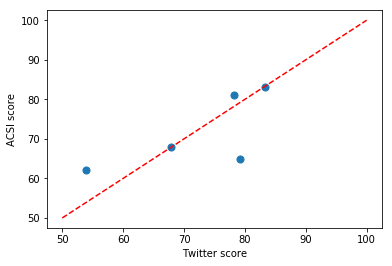

In [58]:
plt.scatter(twitter_score["score"], acsi_score, s=50) # plot points
plt.plot([50, 100], [50, 100], "r--")          # plot a x=y segment
plt.xlabel("Twitter score")
plt.ylabel("ACSI score");

Each point indicates the scores of a company, the dashed line indicates where scores match: the most the points are close to the line, the most the scores agree

To properly verify the agreement of the two scores, we measure the _Pearson's correlation coefficient_

In [59]:
from scipy.stats import pearsonr
pearsonr(twitter_score["score"], acsi_score)

(0.722923515861678, 0.1676117280084561)

The first value is the Pearson's coefficient, while the second value is the associated p-value, i.e. the probability that the correlation between the two series was obtained by chance

### Exercise 1: interpreting negations

In the `sentiment_score` function, when we look for positive or negative words, we do not consider whether they are negated

**A)** The `sentiment_score_neg` function below implements the same logic of `sentiment_score` so that it can be more easily changed: modify it in order to count any positive word immediately preceded by "not" (case-insensitive) as negative and vice versa

In [60]:
def sentiment_score_neg(text, pos_words, neg_words):
    words = nltk.word_tokenize(text)
    score = 0
    for i in range(len(words)):
        word_score = 0
        if words[i] in pos_words:
            word_score = 1
        elif words[i] in neg_words:
            word_score = -1
        score += word_score
    return score

**B)** Create a series `tweet_scores_neg` with scores of tweets in `tweets["text"]`

**C)** Compute the mean absolute difference between this previous score and the new score of each tweet

**D)** Use the `get_summary_scores` defined above to get a series `twitter_score_neg` with summary scores for each airline

**E)** Verify the correlation between the new Twitter score and the ACSI score using a scatter plot and Pearson's coefficient as above

## Activity 2: Sentiment Analysis at sentence and feature level

We reuse techniques seen above to perform sentiment analysis at sentence and feature level on reviews of hotels

TripAdvisor used to provide a summary of hotel ratings against 6 different features: **Location, Sleep Quality, Rooms, Service, Value, Cleanliness**

### Activity plan

1. Define lists of opinion and feature words
  - for opinion words, we reuse the lists of Hu and Liu from above
2. Break reviews into sentences
3. Detect sentences dealing with a specific feature and score its sentiment
4. Summarize evaluation of each hotel and each feature
5. Compare features of each hotel
6. Compare results with scores on TripAdvisor

### Loading reviews

We provide a ZIP file with reviews of 6 different Hotels in Chicago, in a format similar to that of airline tweets used above (one file per hotel, one review per line)

In [61]:
download("hotel-reviews.zip", "https://www.dropbox.com/s/l46r5601h9vjfz9/hotel-reviews.zip?dl=1")

In [62]:
from zipfile import ZipFile
import re
all_reviews = {}
filename_pattern = re.compile("usa_illinois_chicago_([a-z_]+).txt")
with ZipFile("hotel-reviews.zip") as zip:
    for filename in zip.namelist():
        hotel = filename_pattern.match(filename).group(1)
        with zip.open(filename) as f:
            all_reviews[hotel] = list(line.decode(errors="ignore").strip() for line in f)

As an example, we will use reviews for the Intercontinental hotel

In [63]:
reviews_interc = all_reviews["intercontinental_chicago"]

In [64]:
reviews_interc[0]

'A great spot! We have always been pleased with our stays at Intercontinental hotels. Chicago was especially pleasant with a helpful staff.'

### Lists of feature words

To detect sentences dealing with a specific feature, we search for feature-related keywords

Using only the names of the 6 features as keywords, would produce few results: lists of _feature words_ which are synonyms or anyhow else related to each feature is created (manually in this case)

In [65]:
feature_words = {
    'location': {'location', 'airport', 'center', 'island', 'lake', 'ocean',
                 'sea', 'around', 'university', 'romantic', 'coast', 'beach',
                 'disco', 'nightlife'},
    'sleepquality': {'silence','sleep','night','noise','nightlife'},
    'rooms': {'room', 'rooms', 'space', 'bed', 'bath', 'bathroom', 'toilet',
              'degrade', 'disorder','shower','jacuzzi','frigo'},
    'service': {'service','pet','friendly','swimming', 'pool', 'pools', 'spa',
                'waiters', 'severs', 'waiter', 'manservant', 'cordial',
                'hearty', 'restorative', 'disagreeable', 'unpleasant',
                'restaurant', 'food', 'breakfast', 'lunch', 'dinner', 'bar'},
    'value': {'cheap','affordable','afford','woth', 'price', 'value', 'cost',
              'expensive', 'economical', 'depreciate', 'discount', 'luxury',
              'hall', 'meal'},
    'cleanliness': {'clean', 'cleanliness', 'place', 'neatness', 'sweeping',
                    'dirty', 'soiled', 'grubby', 'foul', 'mucky'}
}

### Breaking reviews into sentences

We break reviews into single sentences, assuming that each sentence deals with (at most) one of the features

Breaking text into sentences (_sentence tokenization_) is not straightforward: sentences usually end with a period ("."), but may also end with other punctuation ("!", "?")

This is an example of function for sentence tokenization, which splits text on ".", "?" and "!"

In [66]:
def my_sent_tokenizer(text):
    return re.split("[\\.\\?!]", text)

In [67]:
my_sent_tokenizer(reviews_interc[0])

['A great spot',
 ' We have always been pleased with our stays at Intercontinental hotels',
 ' Chicago was especially pleasant with a helpful staff',
 '']

However this function fails when these characters are used in the middle of a sentence, e.g. in an ellipsis

In [68]:
my_sent_tokenizer("This works... or not? Maybe not.")

['This works', '', '', ' or not', ' Maybe not', '']

Similarly to the word tokenizer used above, NLTK provides a sentence tokenizer based on knowledge of English language to detect such exceptions

In [69]:
nltk.sent_tokenize("This works... or not? Maybe not.")

['This works... or not?', 'Maybe not.']

Using this tokenization function, we turn the list of reviews into a list of single sentences

In [70]:
sentences_interc = [sent for review in reviews_interc for sent in nltk.sent_tokenize(review)]

### Detecting features and opinions in sentences

We define a function which counts, for each feature, the number of sentences in a given list expressing a positive or negative judgement about it

In [71]:
def feature_pos_neg_counts(sentences, feature_words, pos_words, neg_words):
    # initialize to 0 counts of positive and negative sentences per feature
    pos_counts = {feat: 0 for feat in feature_words.keys()}
    neg_counts = {feat: 0 for feat in feature_words.keys()}
    for sent in sentences:
        # evaluate sentiment of sentence
        word_list = nltk.word_tokenize(sent)
        pos_word_count = sum(1 for word in word_list if word in pos_words)
        neg_word_count = sum(1 for word in word_list if word in neg_words)
        sent_score = pos_word_count - neg_word_count
        # detect features in sentence
        word_set = set(word_list)
        for feat, keywords in feature_words.items():
            if word_set & keywords:   # if intersection is not empty
                if sent_score > 0:
                    pos_counts[feat] += 1
                elif sent_score < 0:
                    neg_counts[feat] += 1
    return pd.DataFrame({"pos_count": pos_counts, "neg_count": neg_counts})

For each list of sentences, the function returns a DataFrame with counts of positive and negative sentences for each feature

Let's apply it for example to reviews of Intercontinental

In [72]:
scores_interc = feature_pos_neg_counts(sentences_interc, feature_words, hu_liu_pos, hu_liu_neg)

In [73]:
scores_interc

,neg_count,pos_count
cleanliness,11,131
location,18,231
rooms,92,423
service,55,370
sleepquality,28,50
value,34,70


### Summarizing evaluation of hotel features

Similarly to above, we compute for each feature a sentiment score in a 0-50 scale from the ratio of positive sentences about a feature w.r.t. their total

In [74]:
scores_interc["tot_count"] = scores_interc.pos_count + scores_interc.neg_count

In [75]:
scores_interc["score"] = round(50 * scores_interc.pos_count / scores_interc.tot_count)

In [76]:
scores_interc

,neg_count,pos_count,tot_count,score
cleanliness,11,131,142,46.0
location,18,231,249,46.0
rooms,92,423,515,41.0
service,55,370,425,44.0
sleepquality,28,50,78,32.0
value,34,70,104,34.0


In order to easily repeat this process for every hotel, we wrap it in a function which takes as input the list of reviews and returns the Series with the final scores per feature

In [77]:
def feature_scores(reviews, feature_words, pos_words, neg_words):
    sentences = [sent for review in reviews for sent in nltk.sent_tokenize(review)]
    counts = feature_pos_neg_counts(sentences, feature_words, pos_words, neg_words)
    total = counts.pos_count + counts.neg_count
    return round(50 * counts.pos_count / total)

In [78]:
feature_scores(reviews_interc, feature_words, hu_liu_pos, hu_liu_neg)

cleanliness     46.0
location        46.0
rooms           41.0
service         44.0
sleepquality    32.0
value           34.0
dtype: float64

Let's create a DataFrame with feature scores for all analyzed hotels

In [79]:
scores = pd.DataFrame({hotel: feature_scores(reviews, feature_words, hu_liu_pos, hu_liu_neg) for hotel, reviews in all_reviews.items()})

In [80]:
scores.T   # transpose the table

,cleanliness,location,rooms,service,sleepquality,value
affinia_chicago,46.0,45.0,42.0,45.0,25.0,39.0
hyatt_regency_chicago,42.0,45.0,37.0,39.0,27.0,30.0
intercontinental_chicago,46.0,46.0,41.0,44.0,32.0,34.0
james_chicago,46.0,47.0,41.0,44.0,30.0,35.0
swissotel_chicago,46.0,44.0,40.0,43.0,32.0,34.0
the_palmer_house_hilton,44.0,45.0,37.0,40.0,26.0,35.0


We can create a bar plot to compare the hotels by each feature

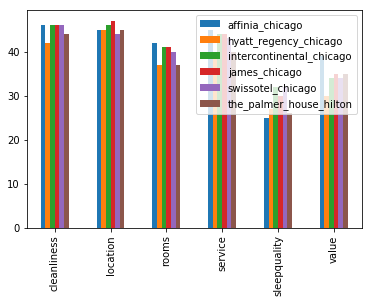

In [81]:
scores.plot.bar()

### Comparing scores with TripAdvisor

Obtained scores can be compared with the feature ratings which were computed by TripAdvisor up to some time ago

![hotel ratings](https://www.dropbox.com/s/pq6q9ugsaessow6/hotel-ratings.png?dl=1)

## Activity 3: Classification of Reviews via Supervised Training

**Goal:** classify user reviews of movies extracted from IMDB as positive or negative

Contrarily to previous activities, this time we will train a classificaton model on existing reviews instead of using manually set keywords

### Loading reviews

We load reviews from a GZIP-compressed CSV file of 10,000 movie reviews, alternated between positive and negative

In [82]:
download("acl-10k.csv.gz", "https://www.dropbox.com/s/ug8pr2v53wxntxb/acl-10k.csv.gz?dl=1")

In [83]:
reviews = pd.read_csv("acl-10k.csv.gz", sep="\t", header=None, names=["label", "text"], compression="gzip")

In [84]:
reviews.head()

,label,text
0,pos,Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school l...
1,neg,Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a t...
2,pos,"If you like adult comedy cartoons, like South Park, then this is nearly a similar format about t..."
3,neg,Robert DeNiro plays the most unbelievably intelligent illiterate of all time. This movie is so w...
4,pos,"Bromwell High is nothing short of brilliant. Expertly scripted and perfectly delivered, this sea..."


In order to validate the goodness of automated classification, we use the _hold-out_ approach: a part of the reviews is used to train a classifier, while the remaining ones are used to assess its accuracy

Let's select the first half of the reviews as the _training set_ and the second half as the _test set_

In [85]:
reviews_train = reviews[:5000]
reviews_test = reviews[5000:]

### Bag of Words and Vector Space Model

In order to train and use a classifier on reviews, we have to define the _features_ which represent them

With the _Bag of Words_ model we represent each review as the set of words contained in it, regardless of their order

Once defined a set of known words, we can represent each review with a vector indicating for each word the number of occurrencies in the text; a set of reviews can be be consequently represented as a _document-term matrix_ with a row vector for each review

Let's define a list of example text documents...

In [86]:
docs = [
    "the sky is blue",
    "sky is blue and sky is beautiful",
    "the beautiful sky is so blue",
    "i love blue cheese"
]

A `CountVectorizer` extracts a vector for each document with counts of distinct words in it: we start from creating an "empty" vectorizer

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

We use the `fit_transform` method passing the list of documents to

- "build" the vector space with dimensions corresponding to words within them (_fit_)
- return the document-term matrix representing them (_transform_)

In [88]:
dtm = vect.fit_transform(docs)

The obtained `dtm` matrix contains a row for each document and a column for each distinct word found within documents: we can obtain a list of the words "learned" by the vectorizer...

In [89]:
vect.get_feature_names()

['and', 'beautiful', 'blue', 'cheese', 'is', 'love', 'sky', 'so', 'the']

Let's view the matrix as a DataFrame, labeling rows and columns with corresponding documents and features

In [90]:
pd.DataFrame(dtm.toarray(), index=docs, columns=vect.get_feature_names())

,and,beautiful,blue,cheese,is,love,sky,so,the
the sky is blue,0,0,1,0,1,0,1,0,1
sky is blue and sky is beautiful,1,1,1,0,2,0,2,0,0
the beautiful sky is so blue,0,1,1,0,1,0,1,1,1
i love blue cheese,0,0,1,1,0,1,0,0,0


As we can see, the matrix indicates for each document the number of occurrencies of each word

Using the `transform` method, we can represent further documents in the same vector space

In [91]:
new_docs = ["loving this blue sky today"]
new_dtm = vect.transform(new_docs)

In [92]:
pd.DataFrame(new_dtm.toarray(), index=new_docs, columns=vect.get_feature_names())

,and,beautiful,blue,cheese,is,love,sky,so,the
loving this blue sky today,0,0,1,0,0,0,1,0,0


Notice that some words of the new document (e.g. "loving") are lost in the representation, because they are not known in the vector space, but this is generally a minor problem if the vector space is built on many documents

### Training a classifier

We use the vector space model to represent reviews passed to a classifier: let's create a new vector space...

In [93]:
vect = CountVectorizer()

...and fit it to reviews of the training set only (as we assume to _not_ know in advance documents of the test set), obtaining the document-term matrix representing them

In [94]:
dtm_train = vect.fit_transform(reviews_train.text)

We can get the total count of extracted feature words...

In [95]:
len(vect.get_feature_names())

36272

...and see some of them (they are in alphabetical order)

In [96]:
vect.get_feature_names()[1000:1005]

['affections', 'affects', 'afficinados', 'affiliated', 'affiliation']

The document-term matrix is _sparse_, meaning that most of its elements are zero. We can verify the ratio of non-zero elements by converting them to booleans and computing the mean value (all non-zero values become 1)

In [97]:
dtm_train.astype(bool).mean()

0.0037657973092192322

Such matrix is represented in memory with a space-efficient data structure which explicitly stores non-zero values only

Now we can train any classification model on the generated vectors: let's use for example a logistic regression model

As for the vectorizer, we first create the "empty" model...

In [98]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="liblinear")

...then we fit it to the training set, passing the vector representation of the reviews along with their actual labels

In [99]:
model.fit(dtm_train, reviews_train.label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

### Using the classifier

Once the classifier is trained, we can use it to estimate labels for further reviews

In [100]:
new_reviews = ["What an awesome movie!", "It was really boring"]

We first have to use the vectorizer to extract their representation in the vector space...

In [101]:
dtm_new = vect.transform(new_reviews)

...then we use the `predict` method of the model to get corresponding predicted labels

In [102]:
model.predict(dtm_new)

array(['pos', 'neg'], dtype=object)

### Evaluating the classifier

We can evaluate the goodness of the classifier by getting predicted labels for reviews in the test set and comparing them with known actual labels

Given data and actual labels of the test set, the `score` method of the model computes the _accuracy_ as the ratio of test reviews for which classification is correct

We first obtain the document-term matrix for the test set...

In [103]:
dtm_test = vect.transform(reviews_test.text)

...then we call the `score` method on it and on the known labels

In [104]:
model.score(dtm_test, reviews_test.label)

0.819

### Creating a pipeline

In all the operations above (training, predicting, evaluating) we had to manually convert text reviews into their vector representations before passing them to the model

scikit-learn allows to create _pipelines_, which combine a prediction model with a sequence of one or more pre-processing steps into a single object

We first create the pipeline by specifying its components, in this case the vectorizer and the actual classifier; each component has a name, allowing it to be referenced after creation

In [105]:
from sklearn.pipeline import Pipeline
model = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", LogisticRegression())
])

Now, we can use the pipeline as we used the model above, but passing directly the text of reviews, as the vectorizer is automatically fit to reviews used to fit the model and used to transform all reviews passed to the classifier

In [106]:
model.fit(reviews_train.text, reviews_train.label);
# ";" is used to suppress output

/home/rrobby/bbs-lab/.venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [107]:
model.predict(new_reviews)

array(['pos', 'neg'], dtype=object)

In [108]:
model.score(reviews_test.text, reviews_test.label)

0.819

We obtain the same result as above, but with cleaner code

### Applying tf.idf term weighting

The `CountVectorizer` generates vectors with simple counts of occurrencies of terms within a document, without considering the relative importance of such terms with respect to each other

The _tf.idf_ term weighting scheme uses a formula with two factors to better evaluate the weight of each term in each document

- The _tf_ factor evaluates the _local_ importance of a term in a document: it is usually the usual count of occurrencies of the term (or its logarithm)
- The _idf_ factor evaluates the _global_ importance of a term in the set of documents: it is higher for terms appearing in fewer documents, as they are supposed to be more specific

In order to use tf.idf in place of raw counts of occurrencies, we simply use `TfidfVectorizer` in place of `CountVectorizer`

Let's see for example the tf.idf applied to example documents used above...

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
dtm = vect.fit_transform(docs)
pd.DataFrame(dtm.toarray(), index=docs, columns=vect.get_feature_names())

,and,beautiful,blue,cheese,is,love,sky,so,the
the sky is blue,0.000,0.000,0.399,0.000,0.488,0.000,0.488,0.000,0.603
sky is blue and sky is beautiful,0.441,0.347,0.230,0.000,0.562,0.000,0.562,0.000,0.000
the beautiful sky is so blue,0.000,0.432,0.286,0.000,0.350,0.000,0.350,0.548,0.432
i love blue cheese,0.000,0.000,0.346,0.663,0.000,0.663,0.000,0.000,0.000


We can see e.g. in the last document that "cheese" has an higher importance than "blue", being a less common and thus more discriminating word

We employ tf.idf in our classification pipeline by replacing `CountVectorizer`

In [110]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("classifier", LogisticRegression())
])

As above, we fit the model on the training set and then evaluate it on the test set

In [111]:
model.fit(reviews_train.text, reviews_train.label);

In [112]:
model.score(reviews_test.text, reviews_test.label)

0.8412

### Looking for the most influential words

Logistic regression computes the likelihood of a review being positive (or negative) according to the following formula:
$$ h_\theta(\mathbf{x})=\frac{1}{1+\exp\left(-\theta_0-\sum_{i=1}^n{\theta_i\cdot x_i}\right)} $$

Every $x_i$ variable indicates the element $i$ of an input vector (i.e. the weight of the $i$-th word in the dictionary), while $\theta_i$ is the model parameter indicating how much the word contributes to the review being estimated as positive or negative

By looking at values of the parameters, we can find out which words contribute the most at the reviews being labeled as positive or negative

The $\theta_i$ parameters are available as the `coef_` attribute of the `LogisticRegression` model, we get it from the pipeline and print some values

In [113]:
model_classifier = model.named_steps["classifier"]
model_classifier.coef_[0, :4]

array([-0.05091047, -0.01439812, -0.02566154,  0.0457697 ])

In order to make sense of the values, we get from the `TfidfVectorizer` the names of features and match them to values using a series

In [114]:
model_vectorizer = model.named_steps["vectorizer"]
model_coefs = pd.Series(model_classifier.coef_[0],
                        model_vectorizer.get_feature_names())

We sort the values in ascending order

In [115]:
model_coefs.sort_values(inplace=True)

Now at the top of the series we find the terms with the lowest coefficients, which make the model decision most tend to the "negative" class

In [116]:
model_coefs.head(5)

bad      -5.200
worst    -4.123
awful    -2.801
waste    -2.771
boring   -2.760
dtype: float64

...while at the bottom of the series we find terms with the highest coefficients, whose presence makes the review positive

In [117]:
model_coefs.tail(5)

and      2.434
well     2.517
love     2.688
best     3.217
great    4.527
dtype: float64

In this way, we can generally find out the most important terms in deciding the orientation of a review

### Regularization of parameters

The logistic regression model uses _regularization_ to prevent parameters from having very high absolute values, which may lead to overfitting

The C parameter controls the regularization strength: smaller values lead to stronger regularization, while larger values make the model fit more to training data

This parameter can be tuned to improve the model accuracy

Let's try for example to raise the C parameter from its default value 1 to 10, thus lowering the regularization

In [118]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("classifier", LogisticRegression(C=10))
])

In [119]:
model.fit(reviews_train.text, reviews_train.label);

In [120]:
model.score(reviews_test.text, reviews_test.label)

0.8292

In this case accuracy slightly drops, possibly due to overfitting

If we check for model parameters, their absolute value are now higher

In [121]:
model_classifier = model.named_steps["classifier"]
model_vectorizer = model.named_steps["vectorizer"]
model_coefs = pd.Series(model_classifier.coef_[0],
                        model_vectorizer.get_feature_names())
model_coefs.sort_values(inplace=True)

In [122]:
model_coefs.head(3)

worst   -9.775
bad     -9.499
awful   -6.672
dtype: float64

In [123]:
model_coefs.tail(3)

perfect    6.163
best       7.489
great      8.935
dtype: float64

### Reducing the dimensionality

Considering the number of distinct terms across all training reviews, the dimensionality of the vector space is very high

In [124]:
len(model_vectorizer.get_feature_names())

36272

Methods exist to reduce the dimensionality in order to lower the time required for training the model with very small repercussion on its accuracy

One possibility is to not consider words appearing only in very few reviews, such as very specific terms or misspelled words

We can configure the vectorizer with the `min_df` parameter to exclude terms appearing e.g. in less than 3 training reviews

In [125]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(min_df=3)),
    ("classifier", LogisticRegression())
])

Let's fit the model as above...

In [126]:
model.fit(reviews_train.text, reviews_train.label);

Looking at the fit vectorizer, the number of dimensions is now much lower...

In [127]:
len(model.named_steps["vectorizer"].get_feature_names())

16127

...but the accuracy is close to the previous value

In [128]:
model.score(reviews_test.text, reviews_test.label)

0.8424

### Stemming

Another way to reduce dimensionality is to group similar terms into an unique feature

_Stemming_ is the extraction of the morphological root (_stem_) of a word: using stems of words as features in place of words themselves, we obtain a single feature for possibly several single terms with a common stem

We start creating a `PorterStemmer` object, providing a `stem` method

In [129]:
ps = nltk.stem.PorterStemmer()

In [130]:
ps.stem("stem"), ps.stem("stemming")

('stem', 'stem')

We can use that to create a function which uses NLTK to tokenize text into words and return a sequence of stems instead of complete words

In [131]:
def tokenize_with_stemming(text):
    return [ps.stem(token) for token
        in nltk.tokenize.word_tokenize(text)]

In [132]:
tokenize_with_stemming("We have shown many examples!")

['We', 'have', 'shown', 'mani', 'exampl', '!']

In a vectorizer, we can set the `tokenizer` parameter to use our custom tokenization function in place of scikit-learn default one

In [133]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(min_df=3, tokenizer=tokenize_with_stemming)),
    ("classifier", LogisticRegression())
])

We can then fit the model as usual

In [134]:
model.fit(reviews_train.text, reviews_train.label);

The number of feature is further reduced

In [135]:
len(model.named_steps["vectorizer"].get_feature_names())

12534

Computing the accuracy...

In [136]:
model.score(reviews_test.text, reviews_test.label)

0.8384

...we see in this case a minor loss 

### n-grams

An _n-gram_ is a sequence of n consecutive words in a text: in the common cases with n equal to 2 and 3, they are called _bigrams_ and _trigrams_

n-grams can be used in addition or replacement to single words as features to represent reviews: they can be useful to spot meaningful expressions composed of more than one word, although we will also get many n-grams with no significant meaning

For example, in the sentence "Sentiment analysis is not bad" we have meaningful bigrams indicating a concept ("Sentiment analysis") and an opinion ("not bad")

Setting the `ngram_range` parameter of a vectorizer to a tuple `(a,b)`, it will use as features all n-grams with n between a and b; the default value is `(1, 1)`, meaning that only single words ("1-grams") are considered

Let's see what happens by setting `(1, 2)`, i.e. considering both single words and bigrams, still limiting features to those appearing in 3 reviews at least

In [137]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(min_df=3, ngram_range=(1, 2))),
    ("classifier", LogisticRegression())
])

Fit the model as usual

In [138]:
model.fit(reviews_train["text"], reviews_train["label"]);

Adding bigrams to single words, the dimensionality is sensibly higher...

In [139]:
len(model.named_steps["vectorizer"].get_feature_names())

71800

...but in this case we successfully increase the accuracy

In [140]:
model.score(reviews_test["text"], reviews_test["label"])

0.851

### Sentiment analysis with NLTK

NLTK integrates specific functions for sentiment analysis, allowing to evaluate the subjectivity and the sentiment of text

Let's see for example how to classify reviews using VADER (_Valence Aware Dictionary for sEntiment Reasoning_), a lexicon and rule-based sentiment estimator specifically oriented to social media, of which NLTK provides an implementation

- **Reference:** Hutto, C. J., and Eric Gilbert. "VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text." _Eighth International AAAI Conference on Weblogs and Social Media_. 2014.

Download the necessary data

In [141]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rrobby/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Import the class and create an analyzer object

In [142]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

We can see some words in the VADER lexicon along with the positive or negative orientation assigned to them: we can see that typical social media language is recognized

In [143]:
vader.lexicon["excellent"]

2.7

In [144]:
vader.lexicon["sux"]

-1.5

In [145]:
vader.lexicon["wtf"]

-2.8

In [146]:
vader.lexicon[":-)"]

1.3

Using the `polarity_score` method, given some text, we obtain a dictionary stating the probability of the sentence being either positive, negative or sentiment-neutral

In [147]:
vader.polarity_scores("Not a bad movie")

{'compound': 0.431, 'neg': 0.0, 'neu': 0.412, 'pos': 0.588}

In [148]:
vader.polarity_scores("I wouldn't recommend this movie")

{'compound': -0.2755, 'neg': 0.413, 'neu': 0.587, 'pos': 0.0}

In [149]:
vader.polarity_scores("This movie is candidated to 3 Academy awards")

{'compound': 0.4588, 'neg': 0.0, 'neu': 0.667, 'pos': 0.333}

We can see that the model is reasonably good in detecting compound statements such as negations

Let's create a function that, given a review, returns a "pos" or "neg" label according to VADER scores

In [150]:
def vader_classify(text):
    scores = vader.polarity_scores(text)
    return "pos" if scores["pos"] >= scores["neg"] else "neg"

Using the `apply` method of series, we apply the function to each review text obtaining a series of pos/neg labels

In [151]:
vader_preds = reviews_test["text"].apply(vader_classify)

We compare this series with actual labels, obtaining a boolean series stating for which reviews the classifier indicated the correct label

In [152]:
vader_hits = vader_preds == reviews_test["label"]

In [153]:
vader_hits.values[:9]

array([ True,  True,  True,  True,  True,  True,  True, False,  True])

Computing the mean, we obtain the ratio of `True` values

In [154]:
vader_hits.mean()

0.6936

Here VADER achieves a lower accuracy than our supervised model, which however required a large set of pre-labeled reviews to be trained

### Exercise 2: test new methods on tweets

In this activity we seen two sentiment classification methods
- using a classifier trained on the labeled reviews used here
- using the pretrained VADER model

Test both these new methods on airline tweets from the first activity, giving each tweet a score of -5 or 5 according to the negative or positive response of the classifier, then compare as above summary scores obtained by both methods with ACSI scores

Which of the two methods do you expect to be more accurate?